In [1]:
import matplotlib.pyplot as plt
import jax
import distrax
import jax.numpy as jnp
import numpy as np
from jax.random import PRNGKey
from chex import assert_equal
import chex
from functools import partial
from tqdm import trange
from matplotlib.colors import LogNorm
import jax.experimental.host_callback as host_callback

In [2]:
gamma = 0.9

class LazyMultivariateNormalMatrix(distrax.Distribution): 
    def __init__(self, mean, scale, triangularized=False):
        self._mean = mean
        self._scale = scale
        self._matrix_dims = mean.shape
        self._prod_dim = np.prod(self._matrix_dims)
        self._triangularized = triangularized

    def mean(self):
        return self._mean

    @property
    def event_shape(self):
        return self._matrix_dims
    
    @property
    def batch_shape(self):
        # return self._mean.shape[:-2]
        return ()

    def _flatten_event(self, x):
        return x.reshape(self._prod_dim)
    
    def _unflatten_event(self, x):
        return x.reshape(*self.batch_shape, *self._matrix_dims)
    
    def _triangularize_scale(self):
        # if not self._triangularized:
        scale = self._scale.reshape(self._prod_dim, self._prod_dim)
        triangularized_scale = (lambda s: jnp.linalg.cholesky( (s @ s.T) + 1e-6 * jnp.eye(s.shape[0])))(scale)
            # self._scale = triangularized_scale.reshape(*self._matrix_dims, *self._matrix_dims)
        return triangularized_scale

    def _build_mvn_tri(self):
        scale = self._triangularize_scale()
        multivariate_normal = distrax.MultivariateNormalTri(
            self._mean.reshape(self._prod_dim), 
            scale.reshape(self._prod_dim, self._prod_dim),
        )
        return multivariate_normal
    
    def log_prob(self, x):
        multivariate_normal = self._build_mvn_tri()
        return multivariate_normal.log_prob(self._flatten_event(x))

    def _sample_n(self, key: PRNGKey, n: int):
        iid_normals = jax.random.normal(key, shape=(n, self._prod_dim, 1))
        samples = self._mean.reshape(self._prod_dim, 1) + jnp.matmul(self._scale.reshape(1,self._prod_dim, self._prod_dim), iid_normals)
        return self._unflatten_event(samples[..., 0])
    
    def variance(self):
        multivariate_normal = self._build_mvn_tri()
        return multivariate_normal.variance().reshape(*self._matrix_dims)
    
def initialize(S, A, scale=1., with_terminal=False):
    means = jnp.zeros((S, A))
    scale = (jnp.eye(S * A, S * A) * scale).reshape((S, A, S, A))
    if with_terminal:
        scale = scale.at[-1, :, -1, :].set(1e-8)
    return LazyMultivariateNormalMatrix(means, scale)

In [3]:
def mdp_solve(T, R):
    S, A = R.shape
    pi = jax.nn.one_hot(jnp.ones(S, dtype=jnp.int32), num_classes=A)

    def loop_body(args):
        pi, _, _ = args
        T_pi = (T[:, :, :, None] * pi[None, None, :, :]).reshape(S * A, S * A)
        q_values = jnp.linalg.solve(jnp.eye(S * A) - gamma * T_pi, R.reshape(S * A)).reshape(S, A)
        pi_new = greedy_policy(q_values)
        return pi_new, pi, q_values
    
    def cond_fun(args):
        pi, prev_pi, _ = args
        return ~jnp.allclose(pi, prev_pi)

    init_val = (pi, jnp.zeros_like(pi), jnp.zeros_like(pi))
    pi, _, q_values = jax.lax.while_loop(cond_fun, loop_body, init_val)
    return pi, q_values

def generate_TR(key, S, A):
    alpha = jnp.ones((S, A, S))
    t_key, r_key = jax.random.split(key, 2)
    T = jax.random.dirichlet(t_key, alpha)
    R = jax.random.normal(r_key, (S, A))
    return T, R


def greedy_policy(q):
    pi = (q == jnp.max(q, axis=1, keepdims=True))
    pi = pi / pi.sum(axis=1, keepdims=True)
    return pi

def dist_policy_evaluation(D_transitions, D_rewards, ll_scale, pi, scale=2., terminal=False):
    S, A = D_rewards.shape
    dist = initialize(S, A, scale=scale, with_terminal=terminal)

    mask = (D_transitions.sum(axis=-1) > 0).flatten()[:, None].astype(jnp.float32)
    
    if terminal:
        mask = mask.at[-1].set(0.)


    noise = jnp.diag(ll_scale**2 / (0.001 + D_transitions.sum(axis=-1).flatten()))
    noise = jnp.sqrt(jnp.diag(mask.flatten()) * noise)

    T_hat = D_transitions / (jnp.sum(D_transitions, axis=-1, keepdims=True) + 1e-16)
    lr = 0.5
    scale_lr = lr
    def body_fun(carry, unused):
        dist = carry
        contraction = jnp.eye(S * A, S * A) * (1 - mask) + gamma * mask * (T_hat[:, :, :, None] * pi[None, :, :]).reshape(S * A, S * A)
        contraction = contraction
        mean = dist._mean
        scale = dist._scale
        new_mean = (1 - lr) * mean + lr  * (D_rewards.reshape(S * A) + contraction @ mean.reshape(S * A)).reshape(S, A)
        new_scale = (1 - scale_lr) * scale + scale_lr * (contraction @ scale.reshape(S * A, S * A) + noise).reshape(S, A, S, A)
        dist = LazyMultivariateNormalMatrix(new_mean, new_scale)
        return dist, dist

    dist, dists = jax.lax.scan(body_fun, dist, jnp.arange(1000))
    loop_info = dict(dists=dists)
    return dist, loop_info

def policy_evaluation(pi, T, R):
    S, A = R.shape
    T_pi = (T[:, :, :, None] * pi[None, None, :, :]).reshape(S * A, S * A)
    Q_values = jnp.linalg.solve(jnp.eye(S * A) - gamma * T_pi, R.reshape(S * A)).reshape(S, A)
    return Q_values

def deterministic_policy_evaluation(Q_pi, T, R):
    S, A = R.shape
    pi = greedy_policy(Q_pi)
    T_pi = (T[:, :, :, None] * pi[None, None, :, :]).reshape(S * A, S * A)
    Q_values = jnp.linalg.solve(jnp.eye(S * A) - gamma * T_pi, R.reshape(S * A)).reshape(S, A)
    return (Q_values * pi).sum(axis=1)

In [4]:
rng_key = jax.random.PRNGKey(42)
rng_key, tr_key, pi_key = jax.random.split(rng_key, 3)
T, R = generate_TR(tr_key, 1, 2)
pi = jax.random.dirichlet(pi_key, jnp.ones((1, 2)))

dist, loop_info = dist_policy_evaluation(T, R, 0.1, pi)

loop_info['dists'].mean().shape

policy_value = policy_evaluation(pi, T, R).flatten()

print(R, pi)

[[ 0.05192758 -0.7084503 ]] [[0.4352794 0.5647206]]


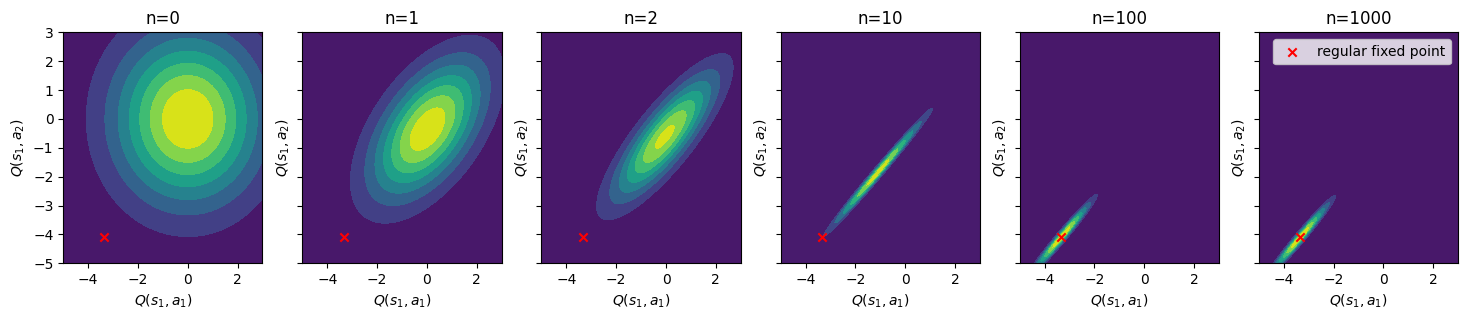

In [73]:
import matplotlib.pyplot as plt
from matplotlib import colors

cmap = "viridis"

def plot_density(ax, dist):
    x_axis = jnp.linspace(-5, 3, 200)

    def density(x, y):
        q = jnp.array([x, y]).reshape(1, 2)
        return jnp.exp(dist.log_prob(q))
    
    density_grid = jax.vmap(jax.vmap(density, in_axes=(0, None)), in_axes=(None, 0))(x_axis, x_axis)
    ax.contourf(x_axis, x_axis, density_grid, cmap=cmap)

fig, axes = plt.subplots(1, 6, figsize=(18, 3), sharey=True)

steps = [0, 1, 9, 99, 999]
dist_list = [initialize(1, 2, scale=2.0)] + [jax.tree_util.tree_map(lambda x: x[step], loop_info['dists']) for step in steps]
steps = [-1] + steps

for i in range(axes.shape[0]):

    dist_ = dist_list[i]

    plot_density(axes[i], dist_)
    axes[i].set_title(f'n={steps[i] + 1}')
    axes[i].scatter(policy_value[0], policy_value[1], color='red', marker='x', label='regular fixed point')

    axes[i].set_xlabel(r"$Q(s_1, a_1)$")
    axes[i].set_ylabel(r"$Q(s_1, a_2)$")


axes[i].legend()

plt.savefig("contraction_dists_viridis.pdf", bbox_inches="tight")

In [74]:
plt.rcParams["text.usetex"] = True

def compute_square_and_root(C):
    square = C @ C.T 
    output = jnp.linalg.eigh(square)
    square_root = output.eigenvectors @ jnp.diag(jnp.sqrt(output.eigenvalues)) @ output.eigenvectors.T
    return square, square_root

def compute_root(C):
    output = jnp.linalg.eigh(C)
    square_root = output.eigenvectors @ jnp.diag(jnp.sqrt(output.eigenvalues)) @ output.eigenvectors.T
    return square_root

def wasserstein(dist_1, dist_2):
    m_1 = dist_1.mean().flatten()
    m_2 = dist_2.mean().flatten()

    
    L_1 = dist_1._triangularize_scale()
    C_1, R_1 = compute_square_and_root(L_1)
    L_2 = dist_2._triangularize_scale()
    C_2, R_2 = compute_square_and_root(L_2)

    root = compute_root(R_2 @ C_1 @ R_2)
    distance = jnp.sum( (m_1 - m_2)**2) + jnp.trace(C_1 + C_2 - 2 * root)
    return distance


distances = []
loop_length = 100
# loop_length = loop_info['dists'].mean().shape[0]
for i in range(loop_length):
    dist_ = jax.tree_util.tree_map(lambda x: x[i], loop_info['dists'])
    distances.append(wasserstein(dist_, dist))

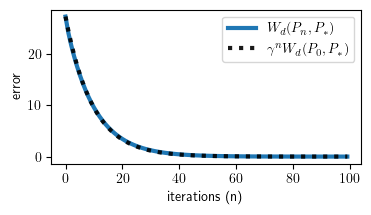

In [120]:
plt.plot(distances, label='$W_d(P_n, P_*)$', linewidth=3.0)
plt.plot(distances[0] * gamma**jnp.arange(len(distances)), color='black', linestyle=':', label="$\gamma^nW_d(P_0, P_*)$", linewidth=3.0, alpha=0.9)
plt.legend()
plt.ylabel("error")
plt.gcf().set_size_inches(4, 2)
plt.xlabel('iterations (n)')
plt.savefig('contraction.pdf', bbox_inches="tight")